<a href="https://colab.research.google.com/github/LanqingDu/PrescriptiveAnalytics/blob/main/Individual_Project_WhatIf_Forecasting.ipynb" target="_blank">
<img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

# **Individual Project Template**



> **Instructor:** Dr. Lanqing Du  
> **Acknowledgement:** Based on R user guide content.  
> **Objective:** Individual project R coding template.  
> **Instructions:** You can preview the **Table of Contents** from the side bar.

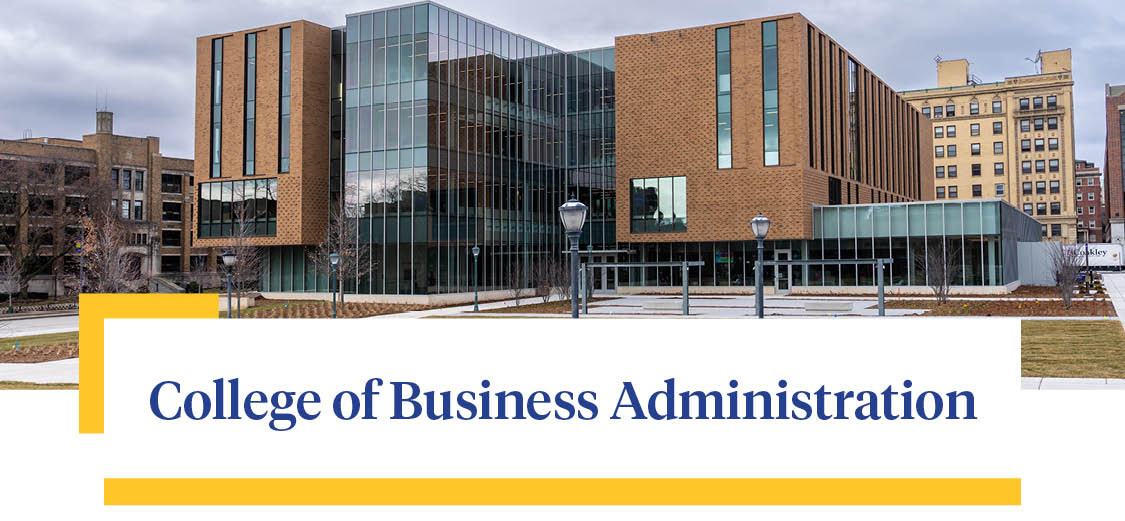
---

## [1. Load Data](#S1)

In [1]:
# ================================
# Step 1: Install and load libraries
# ================================

install.packages("forecast")
install.packages("Metrics")
install.packages("prophet") # a forecasting library developed by Meta
# install.packages("tsintermittent") # for intermittent / sparse demand time series

library(readxl)
library(forecast)
library(tidyverse)
library(Metrics)
library(prophet)
# library(tsintermittent) # for exploration only

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.6
✔ forcats   1.0.1     ✔ stringr   1.6.0
✔ ggplot2   4.0.1     ✔ tibble    3.3.1
✔ lubridate 1.9.4     ✔ tidyr     1.3.2
✔ purrr     1.2.1     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

Attaching package: ‘Metrics’


The following object is masked from ‘package:forecast’:

    accuracy


Loading required package

In [89]:
# ================================
# Step 2: Load data (if mannually upload data)
# ================================

# demo data: https://www.kaggle.com/datasets/roopahegde/cryptocurrency-timeseries-2020


# if data is excel
# data <- read_excel('/content/gemini_BTCUSD_2020_1min.csv')

# if data is csv

data <- read_csv("/content/gemini_BTCUSD_2020_1min.csv")

head(data)
print(colnames(data))

Rows: 658065 Columns: 8
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (2): Date, Symbol
dbl (6): Unix Timestamp, Open, High, Low, Close, Volume

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


Unix Timestamp,Date,Symbol,Open,High,Low,Close,Volume
<dbl>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1.61888e+12,4/20/2021 0:02,BTCUSD,55717.47,55723.00,55541.69,55541.69,2.4067336
1.61888e+12,4/20/2021 0:01,BTCUSD,55768.94,55849.82,55711.74,55717.47,0.5734577
1.61888e+12,4/20/2021 0:00,BTCUSD,55691.79,55793.15,55691.79,55768.94,3.3099037
1.61888e+12,4/19/2021 23:59,BTCUSD,55777.86,55777.86,55677.92,55691.79,0.6849344
1.61888e+12,4/19/2021 23:58,BTCUSD,55803.50,55823.88,55773.08,55777.86,0.4772246
1.61888e+12,4/19/2021 23:57,BTCUSD,55690.64,55822.91,55682.56,55803.50,5.4617165


[1] "Unix Timestamp" "Date"           "Symbol"         "Open"          
[5] "High"           "Low"            "Close"          "Volume"        


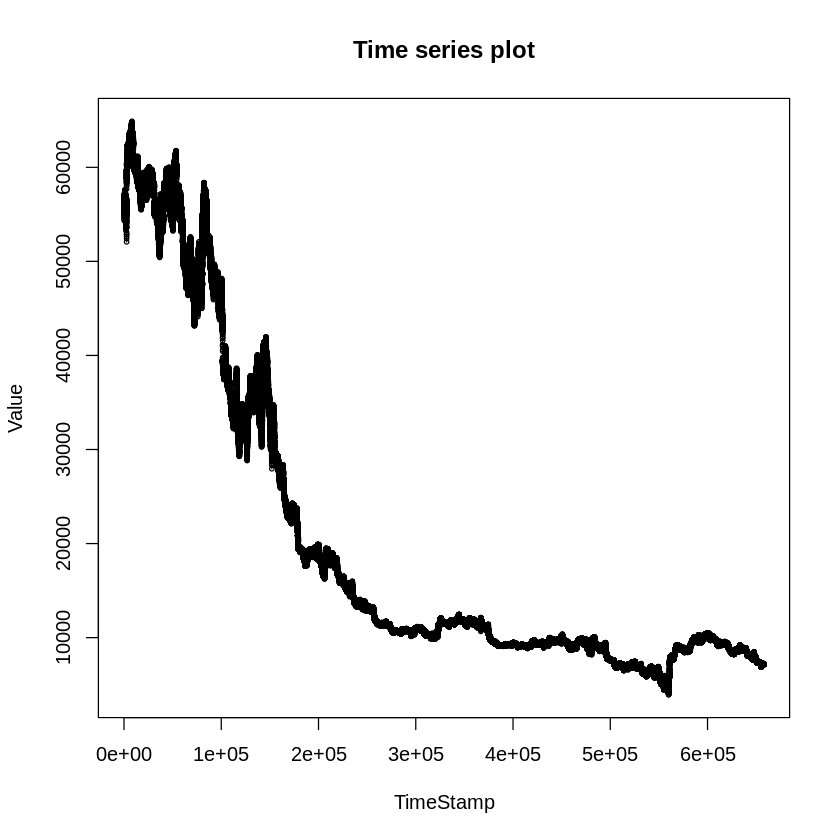

In [90]:
# ================================
# Step 3: Examine time series data
# ================================

## plot(x, y, type = ..., xlab = ..., ylab = ..., main =...)
## type = "o" means both lines and points.
## type = "l" → line only
## type = "p" → points only

# assume forecasting Open data

plot(seq_along(data$Open), data$Open,
     type = "o",
     pch = 1,        # circle
     cex = 0.5,      # smaller points (default = 1)
     xlab = "TimeStamp",
     ylab = "Value",
     main = "Time series plot")


#### For your individual project, briefly describe the time series pattern and explain whether it influenced your choice of forecasting method.

In [91]:
# ================================
# Step 4: Convert to time series data
# ================================


# Convert to timeseries
data_forecast <- data$Open

data_forecast_ts <- ts(data_forecast, frequency = 1)


# Slice the data for comparison
data_out <- data[, c("Date", "Open")]

# # If want to conduct train-test split
# train <- window(ts_data, end = c(1959, 12))
# test  <- window(ts_data, start = c(1960, 1))
# h <- length(test)

In [183]:
# ================================
# Step 5: Helper function (evaluation)
# NOTE: This project is designed for evaluating modeling fit (in-sample)
# ================================

# Defined function for return the forecasting errors

evaluate_forecast <- function(actual, forecasted) {
  # Remove NA or NaN values
  valid_idx <- which(!is.na(actual) & !is.na(forecasted))

  actual_clean    <- actual[valid_idx]
  forecasted_clean <- forecasted[valid_idx]

  tibble(
    RMSE = rmse(actual_clean, forecasted_clean),
    MAE  = mae(actual_clean, forecasted_clean),
    MAPE = mape(actual_clean, forecasted_clean)
  )
}


## [2. Model Option 1 - SMA](#M1)

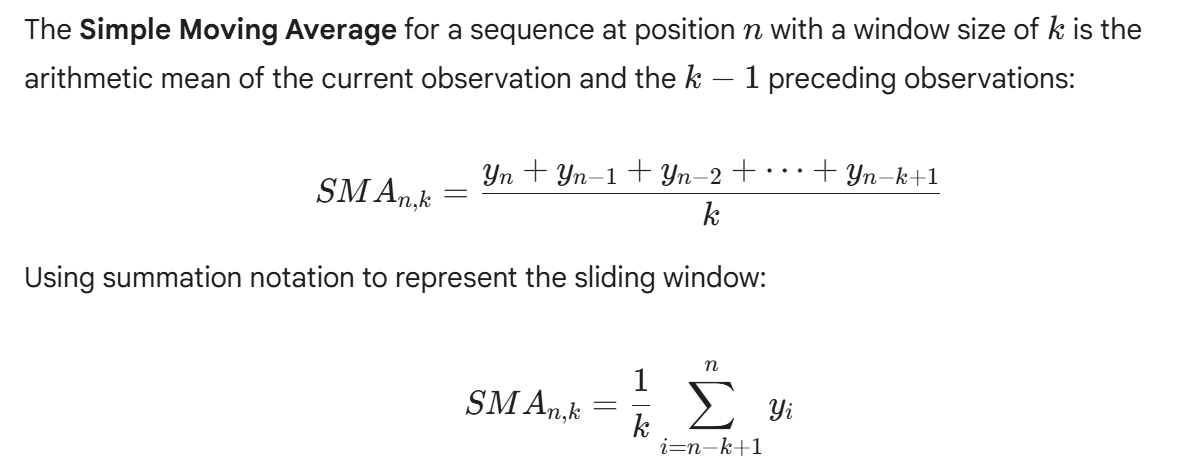

In [178]:
# ================================
# Step 6: Model Option 1 Simple Moving Avg
# ================================

run_sma_forecasts <- function(k_values) {

  # Loop over each k and compute forecast
  for (k in k_values) {

    # Compute SMA forecast using forecast()
    fc <- TTR::SMA(data_forecast, n = k)

    # Add forecasted values as a new column
    col_name <- paste0("SMA(k=", k, ")")
    data_out[[col_name]] <- fc
  }

  return(data_out)
}




In [179]:
# ================================
# Step 7 - V1: DATA-TABLE for Simple Moving Avg
# ================================

k_values <- c(3, 6, 12)

sma_forecasts <- run_sma_forecasts(k_values)

head(sma_forecasts,20)


Date,Open,SMA(k=3),SMA(k=6),SMA(k=12)
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
4/20/2021 0:02,55717.47,NA,NA,NA
4/20/2021 0:01,55768.94,NA,NA,NA
4/20/2021 0:00,55691.79,55726.07,NA,NA
4/19/2021 23:59,55777.86,55746.20,NA,NA
4/19/2021 23:58,55803.50,55757.72,NA,NA
4/19/2021 23:57,55690.64,55757.33,55741.70,NA
4/19/2021 23:56,55624.69,55706.28,55726.24,NA
4/19/2021 23:55,55651.82,55655.72,55706.72,NA
4/19/2021 23:54,55688.08,55654.86,55706.10,NA


In [184]:
# ================================
# Step 8 - V1: Error Terms
# ================================

evaluate_forecast(sma_forecasts$Open, sma_forecasts$`SMA(k=3)`)


RMSE,MAE,MAPE
<dbl>,<dbl>,<dbl>
26.24709,11.86302,0.0005073446


## [3. Exponential Smoothing](#M2)
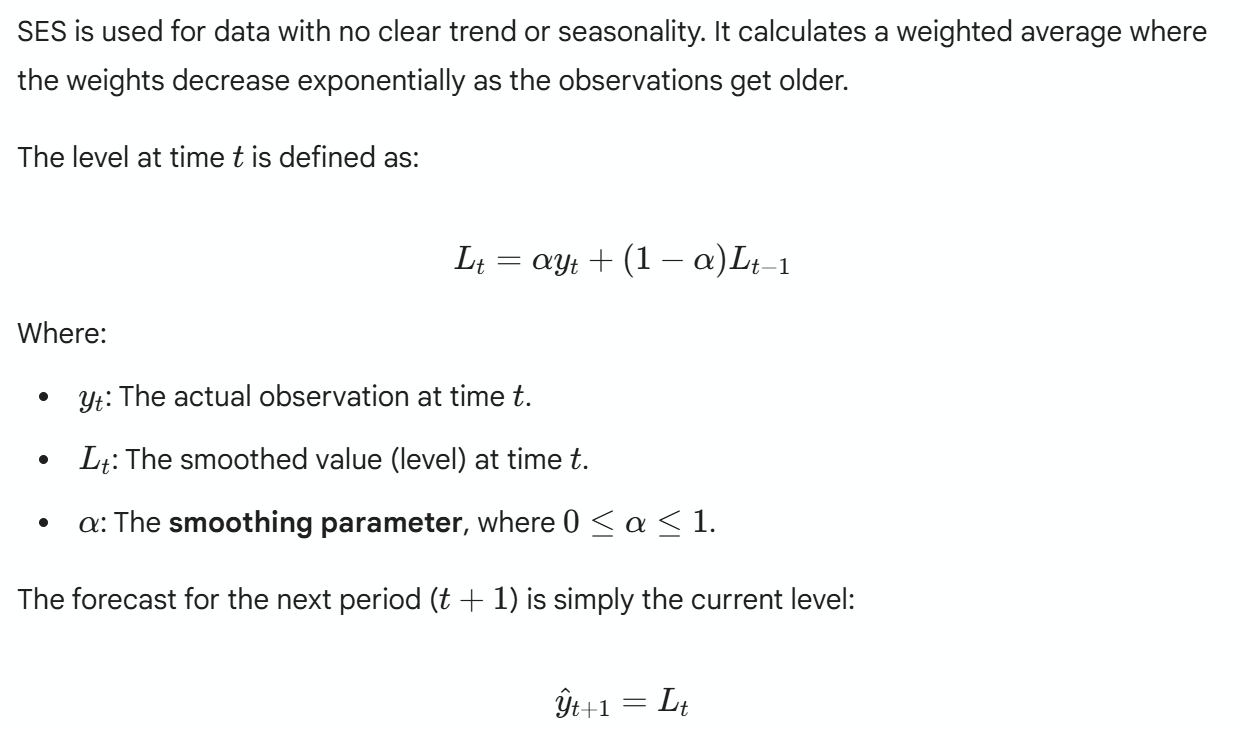

In [102]:
# ================================
# Step 6: Model Option 2 Exponential Smoothing
# ================================

# NOTE: we set beta = false and gamma = false for exponential smoothing
# DISCLAIMER: though we can call es() function to get optimal alpha, for
#             this project, we apply a data table similiar approach to
#             explore the influence of alpha

run_es_forecasts <- function(alpha) {
  for (a in alpha_values) {

    # Fit Simple Exponential Smoothing using HoltWinters
    fit <- HoltWinters(data_forecast_ts, alpha = a, beta = FALSE, gamma = FALSE)

    # Extract the smoothed values (level)
    smoothed <- fit$fitted[, "xhat"]
    smoothed_aligned <- c(NA, smoothed)

    # Add smoothed series as a new column
    col_name <- paste0("SES(alpha=", a, ")")
    data_out <- cbind(data_out, smoothed_aligned)
    colnames(data_out)[ncol(data_out)] <- col_name
  }

  return(data_out)
}


In [185]:
# ================================
# Step 7 - V2: DATA-TABLE for Exponential Smoothing
# ================================

alpha_values <- c(0.2, 0.5, 1)

es_forecasts <- run_es_forecasts(alpha_values)

head(es_forecasts,20)

,Date,Open,SES(alpha=0.2),SES(alpha=0.5),SES(alpha=1)
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
1,4/20/2021 0:02,55717.47,NA,NA,NA
2,4/20/2021 0:01,55768.94,55717.47,55717.47,55717.47
3,4/20/2021 0:00,55691.79,55727.76,55743.21,55768.94
4,4/19/2021 23:59,55777.86,55720.57,55717.50,55691.79
5,4/19/2021 23:58,55803.50,55732.03,55747.68,55777.86
6,4/19/2021 23:57,55690.64,55746.32,55775.59,55803.50
7,4/19/2021 23:56,55624.69,55735.19,55733.11,55690.64
8,4/19/2021 23:55,55651.82,55713.09,55678.90,55624.69
9,4/19/2021 23:54,55688.08,55700.83,55665.36,55651.82


In [188]:
# ================================
# Step 8 - V2: Error Terms
# ================================

evaluate_forecast(es_forecasts$Open, es_forecasts$`SES(alpha=0.2)`)

RMSE,MAE,MAPE
<dbl>,<dbl>,<dbl>
57.01296,26.32279,0.001144398


## [4. Holt's Linear Trend](#M3)
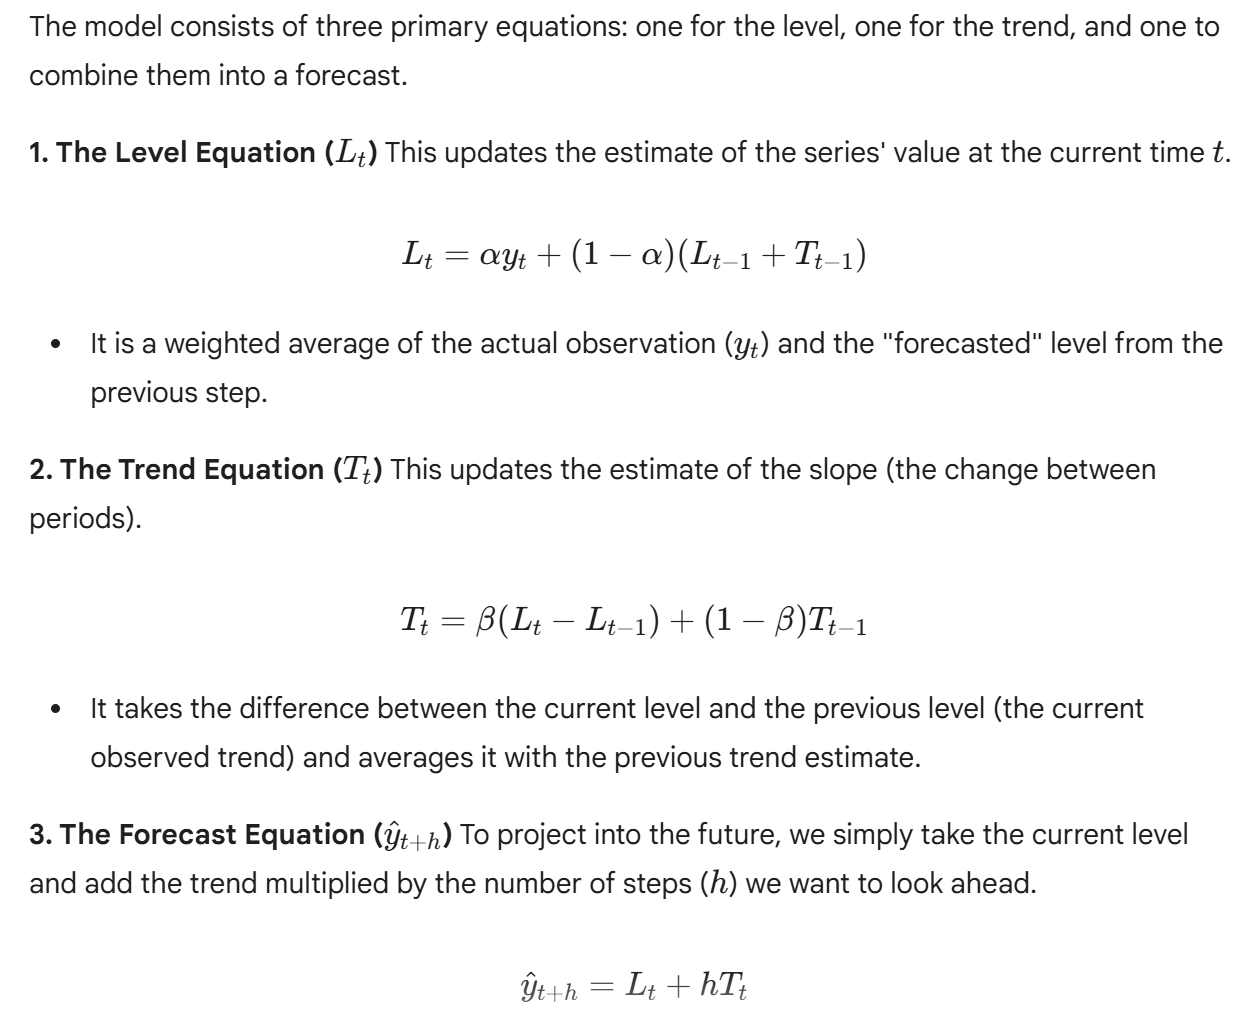

In [189]:
# ================================
# Step 6: Model Option 3 Holt's Linear Trend
# ================================


run_holt_forecasts <- function(alpha_values, beta_values) {
  # Prepare output data frame

  for (a in alpha_values) {
    for (b in beta_values) {

      # Fit Holt's Linear Trend using HoltWinters
      fit <- HoltWinters(
        data_forecast_ts,
        alpha = a,
        beta = b,
        gamma = FALSE
      )

      # Extract the fitted values (level + trend)
      fitted_values <- fit$fitted[, "xhat"]
      fitted_aligned <- c(NA, NA, fitted_values)

      # Create column name
      col_name <- paste0("Holt(alpha=", a, ",beta=", b, ")")

      # Add to output
      data_out <- cbind(data_out, fitted_aligned)
      colnames(data_out)[ncol(data_out)] <- col_name
    }
  }

  return(data_out)
}



In [208]:
# ================================
# Step 7 - V3: DATA-TABLE for Holt's Linear
# ================================

alpha_values <- c(0.2, 0.5, 0.8)
beta_values  <- c(0.1, 0.3, 0.5)

holt_forecasts <- run_holt_forecasts(alpha_values, beta_values)


head(holt_results,20)

,Date,Open,"Holt(alpha=0.2,beta=0.1)","Holt(alpha=0.2,beta=0.3)","Holt(alpha=0.2,beta=0.5)","Holt(alpha=0.5,beta=0.1)","Holt(alpha=0.5,beta=0.3)","Holt(alpha=0.5,beta=0.5)","Holt(alpha=0.8,beta=0.1)","Holt(alpha=0.8,beta=0.3)","Holt(alpha=0.8,beta=0.5)"
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,4/20/2021 0:02,55717.47,NA,NA,NA,NA,NA,NA,NA,NA,NA
2,4/20/2021 0:01,55768.94,NA,NA,NA,NA,NA,NA,NA,NA,NA
3,4/20/2021 0:00,55691.79,55820.41,55820.41,55820.41,55820.41,55820.41,55820.41,55820.41,55820.41,55820.41
4,4/19/2021 23:59,55777.86,55843.58,55838.44,55833.29,55801.14,55788.28,55775.42,55758.69,55738.12,55717.54
5,4/19/2021 23:58,55803.50,55878.02,55866.44,55855.27,55833.37,55813.68,55796.56,55816.74,55800.05,55789.95
6,4/19/2021 23:57,55690.64,55909.21,55890.19,55872.80,55860.82,55837.68,55821.69,55847.80,55833.78,55830.36
7,4/19/2021 23:56,55624.69,55907.22,55874.65,55846.04,55809.60,55771.19,55745.06,55751.15,55715.88,55692.27
8,4/19/2021 23:55,55651.82,55886.78,55834.03,55789.31,55741.77,55683.00,55643.68,55668.95,55617.66,55584.86
9,4/19/2021 23:54,55688.08,55871.16,55796.03,55735.60,55716.93,55647.79,55608.59,55672.84,55627.92,55611.86


In [210]:
# ================================
# Step 8 - V3: Error Terms
# ================================

evaluate_forecast(holt_forecasts$Open, holt_forecasts$`Holt(alpha=0.2,beta=0.1)`)

RMSE,MAE,MAPE
<dbl>,<dbl>,<dbl>
57.98647,27.08537,0.001181142


## [5. Autoregressive](#M4)
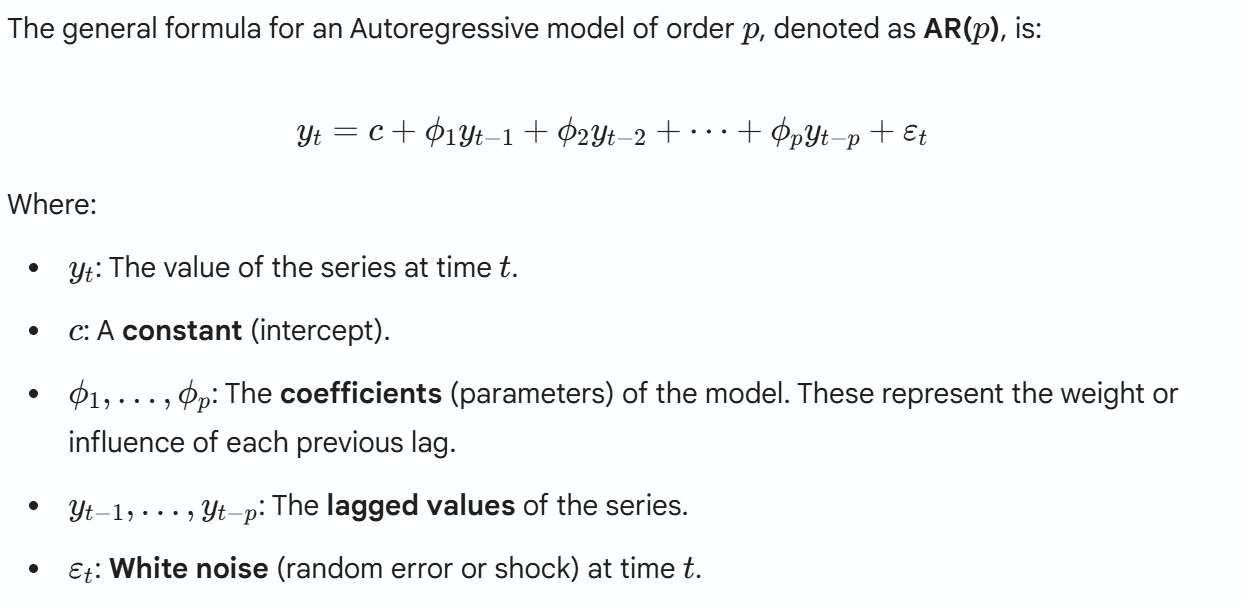

In [200]:
# ================================
# Step 6: Model Option 4 AutoRegressive
# ================================

run_ar_forecasts <- function(p_values) {
  # p_values: Vector of lags, e.g., c(2, 3, 4, 5)
  # other coefficients are automatically calculated by ARIMA function

  for (p in p_values) {
    # Fit pure AR model: ARIMA(p, 0, 0)
    fit <- tryCatch(
      Arima(data_forecast_ts, order = c(p, 0, 0)),
      error = function(e) NULL
    )

    if (!is.null(fit)) {
      # Column name based on the specific lag
      col_name <- paste0("AR_Lag_", p)
      data_out[[col_name]] <- as.numeric(fitted(fit))
    }
  }

  # Return as a structured data frame for in-sample comparison
  return(data_out)
}


In [201]:
# ================================
# Step 7 - V4: DATA-TABLE for AR
# ================================

# Define the number of period lags
p_values <- c(2,3,4,5)


ar_forecasts <-run_ar_forecasts(p_values)

head(ar_forecasts)

Date,Open,AR_Lag_2,AR_Lag_3,AR_Lag_4,AR_Lag_5
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
4/20/2021 0:02,55717.47,55599.93,55600.03,55598.13,55598.21
4/20/2021 0:01,55768.94,55717.28,55717.29,55717.29,55717.29
4/20/2021 0:00,55691.79,55768.27,55768.25,55768.24,55768.24
4/19/2021 23:59,55777.86,55692.32,55691.31,55691.30,55691.30
4/19/2021 23:58,55803.50,55776.86,55778.40,55778.06,55778.06
4/19/2021 23:57,55690.64,55803.07,55801.34,55801.82,55801.87


In [203]:
# ================================
# Step 8 - V4: Error Terms
# ================================

evaluate_forecast(ar_forecasts$Open, ar_forecasts$AR_Lag_2)

RMSE,MAE,MAPE
<dbl>,<dbl>,<dbl>
35.34548,15.79427,0.0006651678


## [6. ARIMA: Autoregressive Integrated Moving Average](#M5)

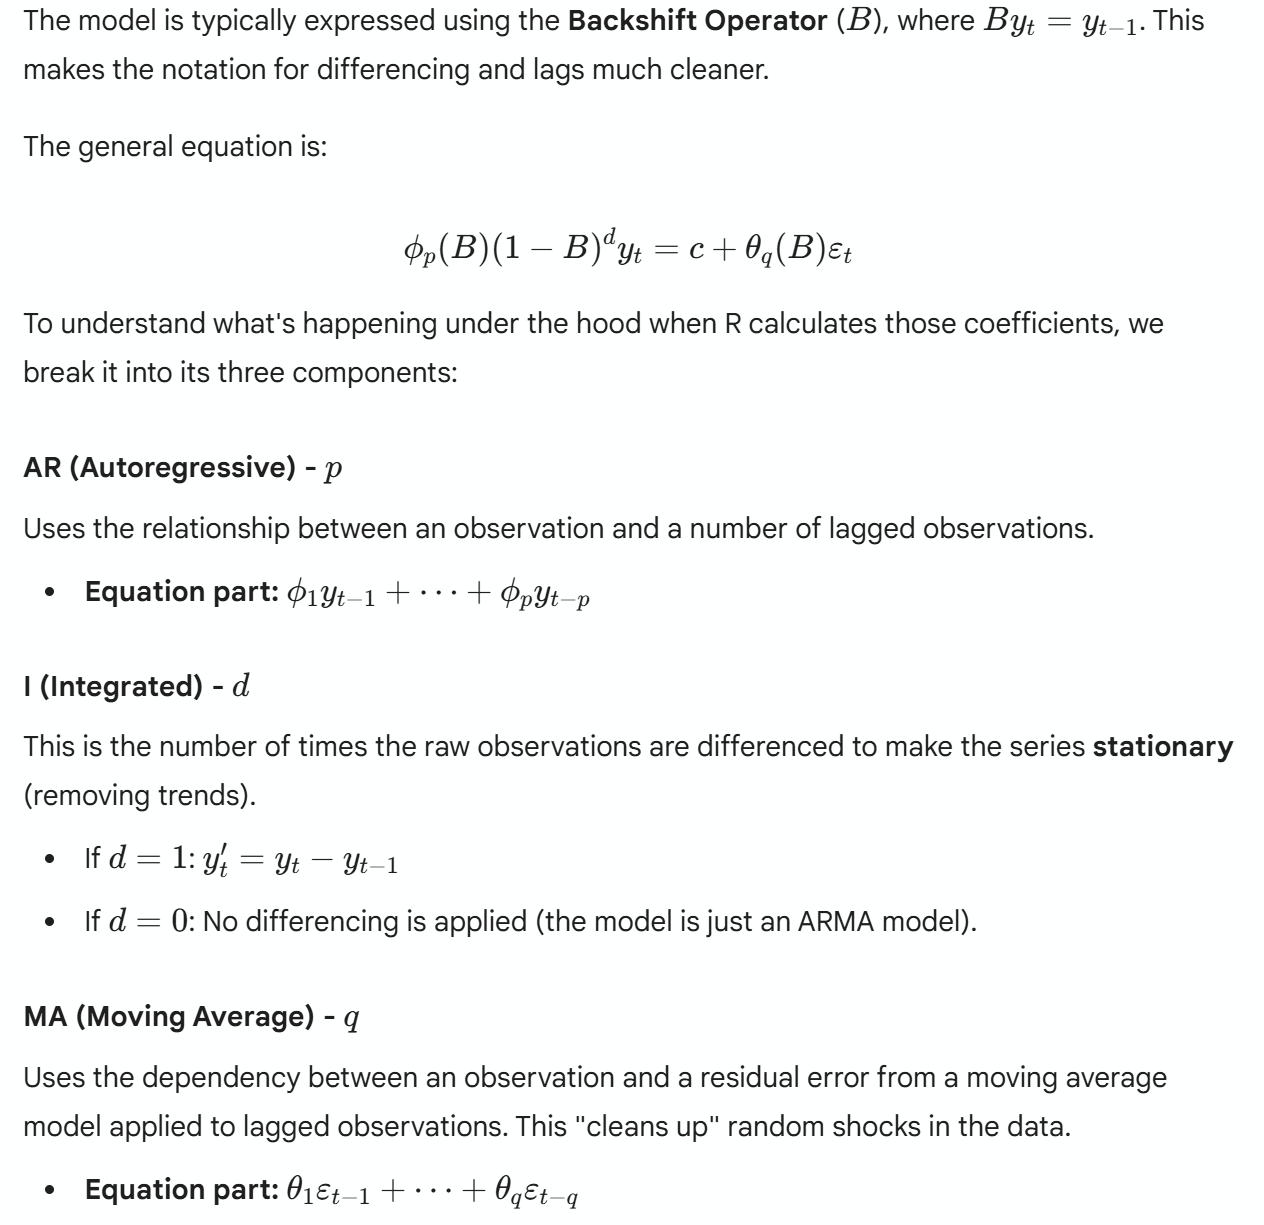

In [204]:
# ================================
# Step 6: Model Option 5 ARIMA
# ================================

run_arima_forecasts <- function(arima_params = NULL) {
  # ts_data: time series object
  # arima_params: list of vectors, e.g., list(c(1,1,1), c(0,1,2))


  if (is.null(arima_params)) {
    # Auto ARIMA
    fit <- auto.arima(data_forecast_ts)
    data_out[[col_name]] <- as.numeric(fitted(fit))

  } else {
    # Iterate through the manual list
    for (order_vec in arima_params) {
      # order_vec is expected to be c(p, d, q)
      fit <- tryCatch(
        Arima(data_forecast_ts, order = order_vec),
        error = function(e) NULL
      )

      if (!is.null(fit)) {
        col_name <- paste0("ARIMA(", paste(order_vec, collapse=","), ")")
        # fitted() gets the in-sample values
        data_out[[col_name]] <- as.numeric(fitted(fit))
      }
    }
  }

  # Return as a data frame
  return(data_out)
}

In [205]:
# ================================
# Step 7 - V5: DATA-TABLE for Arima
# ================================

# 1. Define your combinations as a list of vectors c(p, d, q)
my_combinations <- list(
  c(1, 1, 1),
  c(2, 1, 0),
  c(0, 1, 2)
)


arima_forecasts <- run_arima_forecasts(arima_params = my_combinations)

head(arima_results)

Date,Open,"ARIMA(1,1,1)","ARIMA(2,1,0)","ARIMA(0,1,2)"
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
4/20/2021 0:02,55717.47,55661.75,55661.75,55661.75
4/20/2021 0:01,55768.94,55717.47,55717.48,55717.48
4/20/2021 0:00,55691.79,55768.45,55768.44,55768.43
4/19/2021 23:59,55777.86,55692.53,55691.49,55691.51
4/19/2021 23:58,55803.50,55777.04,55778.59,55778.55
4/19/2021 23:57,55690.64,55803.25,55801.53,55801.52


In [206]:
# ================================
# Step 8 - V5: Error Terms
# ================================

evaluate_forecast(arima_forecasts$Open, arima_forecasts$`ARIMA(0,1,2)`)

RMSE,MAE,MAPE
<dbl>,<dbl>,<dbl>
35.33816,15.79538,0.000665218
